# A Model for Slime Mold Foraging Behavior
**Group ID:** 29

**Presented by:** Kaichao Zheng(24141207), Meng Sun(24002421)

---
👏In short, we tried to imitate this document following our lab style.


# Setup

## Installing Libraries

In [24]:
!pip install matplotlib
!pip install pandas
!pip install seaborn

## Downloading Python Scripts

In [2]:
from os.path import basename, exists

def download(url):
  filename = basename(url)
  if not exists(filename):
    from urllib.request import urlretrieve
    local, _ = urlretrieve(url, filename)
    print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

Downloaded utils.py
Downloaded Cell2D.py


# Custom Color Map

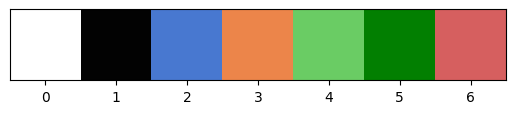

In [1]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

# make a custom color map
palette = sns.color_palette('muted')
colors = ["white", "black", palette[0], palette[1], palette[2], "green", palette[3]]
cmap = LinearSegmentedColormap.from_list("cmap", colors)

# make a color dict
color = {
    "white" : 0,
    "black" : 1,
    "blue" : 2,
    "orange" : 3,
    "light_green" : 4,
    "green" : 5,
    "red" : 6
}

# map item to color
item_color = {
    "path" : color["white"],
    "wall" : color["black"],
    "oat" : color["red"],
    "mold" : color["green"],
    "growth" : color["light_green"]
}

# demo
colors_demo = np.arange(7).reshape(1, -1)
draw_params = {'cmap': cmap, 'vmin': 0, 'vmax': 6, 'alpha': 1}

color_path = item_color["path"]
color_wall = item_color["wall"]
color_oat = item_color["oat"]
color_mold = item_color["mold"]
color_growth = item_color["growth"]

# show palette
plt.imshow(colors_demo, cmap=cmap, vmin=0, vmax=6)
plt.xticks(np.arange(0, colors_demo.shape[1], step=1))
plt.yticks([])  # remove y-axis
plt.show()

# Model Implementation

> Environment: `maze`
* Attribute: `oat_coord`

> Agent: `mold`
* Attribute: `energy`

> Randomness: `seed`
* maze carving direction
* mold foraging direction

In [3]:
from Cell2D import Cell2D, draw_array

class SlimeMoldForaging(Cell2D):

  def __init__(self, height=19, width=19, max_energy=20, seed=12):
      super().__init__(height, width)
      np.random.seed(seed)                                      # global seed to unify visualization performance
      self.height = height                                      # maze shape
      self.width = width
      self.max_energy = max_energy
      self.maze = np.ones((height, width), dtype=np.int8)       # the environment in this model
      self.energy = np.zeros((height, width), dtype=np.int8)    # the agent attribute in this model
      self.start_x = np.random.randint(0, (width // 2)) * 2 + 1
      self.start_y = np.random.randint(0, (height // 2)) * 2 + 1
      self.maze[self.start_y, self.start_x] = 0                 # set starting point as path
      self.stack = [(self.start_x, self.start_y)]               # DFS stack for maze generation
      self.queue = []                                           # BFS queue for mold foraging
      self.action = ""                                          # special text command
      self.path = []                                            # trace foraging path for mold retraction
      self.found = False                                        # found oat flag
      self.oat_path = []                                        # preserve oat path

  def place_item(self, item):
      """randomly place item in maze path"""

      # This model only considers a single slime mold searches for a single oat
      if np.any(self.maze == item_color[item]):
          return

      paths = np.argwhere(self.maze == color_path)
      item_coord = paths[np.random.choice(len(paths))]
      self.maze[item_coord[0], item_coord[1]] = item_color[item]

      if item in ["mold", "oat"]:
        item_x, item_y = int(item_coord[1]), int(item_coord[0])
        self.energy[item_x][item_y] = self.max_energy
        if item == "mold":  # preprocess BFS queue
            self.queue.append((item_x, item_y, [(item_x, item_y)]))

  def carve_pathway_step(self):
      """generate paths using DFS"""

      while self.stack:
        x, y = self.stack[-1]
        carve_directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]
        np.random.shuffle(carve_directions)

        carved = False  # dead end flag to prevent cycle in maze
        for dx, dy in carve_directions:
            nx = x + dx
            ny = y + dy
            if 0 <= nx < self.maze.shape[1] and 0 <= ny < self.maze.shape[0]:
                if self.maze[ny][nx] == color_wall:
                    self.maze[y + dy // 2][x + dx // 2] = 0
                    self.maze[ny][nx] = color_path
                    self.stack.append((nx, ny))
                    carved = True
                    break
        # dead end
        if not carved:
            self.stack.pop()

        # special command for steps visualization
        if "step" in self.action:
            break

  def forage_step(self):
      """mold spreads using BFS with energy constraint"""

      while self.queue:
        x, y, path = self.queue.pop(0)
        forage_directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        for dx, dy in forage_directions:
            nx, ny = x + dx, y + dy

            if 0 <= ny < self.maze.shape[1] and 0 <= ny < self.maze.shape[0]:
              # pseudopodia keep spreading after find the oat
              if self.maze[ny][nx] in [color_path, color_oat]:
                if self.maze[ny][nx] != color_oat:
                  # consume energy when spreading
                  if self.energy[x][y] > 0:
                    self.maze[ny][nx] = color_growth
                    self.energy[nx][ny] = self.energy[x][y] - 1
                    self.queue.append((nx, ny, path+[(nx, ny)]))
                    self.path.append((nx, ny))
                  else:
                    # stop spreading when energy used out
                    continue
                else:
                    # if reaching oat, recharge energy
                    self.found = True
                    self.energy[nx][ny] = self.max_energy
                    self.queue.append((nx, ny, path+[(nx, ny)]))
                    self.oat_path.append(path)

        # special command for steps visualization
        if "step" in self.action:
            break

  def retract_step(self):
      """mold retraction using traced path when foraging"""

      while self.path:
        x, y = self.path.pop()

        # retain the path to oat
        if self.found and (x, y) in self.oat_path[0]:
          continue

        if self.maze[y][x] == 4:
          self.maze[y][x] = 0

        if "step" in self.action:
          break

  def find_oat(self):
      """used for survival rate calculation"""
      return 1 if self.oat_path else 0

  def step(self):
      """model evolves by special text commands in self.progress"""

      if "carve" in self.action:
           self.carve_pathway_step()
      elif "forage" in self.action:
           self.forage_step()
      elif "retract" in self.action:
           self.retract_step()

  def draw(self, nparray="maze"):
      draw_array(getattr(self, nparray), **draw_params)

  def draw_with_energy(self, array=None, annotations=None):
      """port annotate_ca_text(array, annotations) from CA lab2"""

      if array is None:
        array = self.maze
      if annotations is None:
        annotations = self.energy

      rows, cols = array.shape
      ax = plt.gca()

      # Remove minor ticks
      ax.tick_params(which='minor', bottom=False, left=False)

      for i in range(annotations.shape[0]):
        for j in range(annotations.shape[1]):
          ax.text(i, j, str(annotations[i, j]), ha='center', va='center', fontsize=10)

      plt.imshow(array, cmap=cmap, vmin=0, vmax=6, interpolation='none')
      plt.axis('off')

  def three_frame(self, n_seq):
      """port three_frame() from utils.py"""
      plt.figure(figsize=(10, 4))

      for i, n in enumerate(n_seq):
        plt.subplot(1, 3, i+1)
        self.loop(n)
        self.draw()

      plt.tight_layout()

# Maze Initialization



## 1.1 Carving Pathway

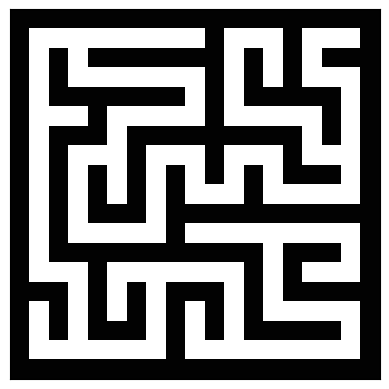

In [4]:
# width and height should preferably be odd nunmbers
env = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)    # seed = 12 has good features in recharge and retraction
env.action = "carve_pathway"
env.step()
env.draw()

## 1.2 Place Mold and Oat

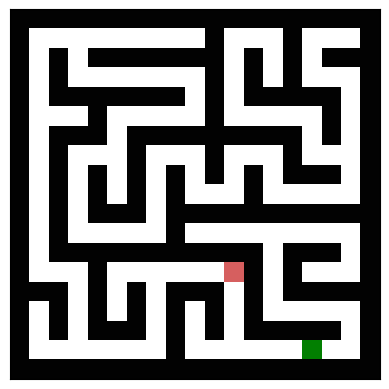

In [5]:
env.place_item("mold")                                                  # present mold in green
env.place_item("oat")                                                   # present oat in red
env.draw()

## 1.3 Progress Visualization

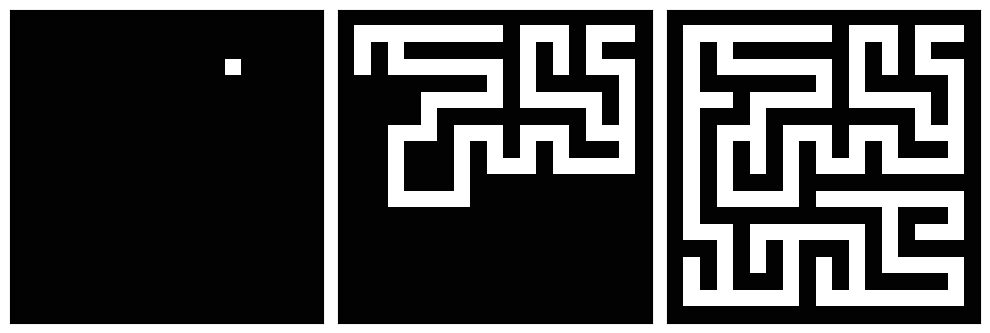

In [6]:
# Pathway carving frames
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)   # seed = 12 has good features in recharge and retraction
demo.action = "carve_pathway_in_steps"
demo.three_frame([0, 50, 100])                                          # display carving frames at 0, 50 and 150 steps

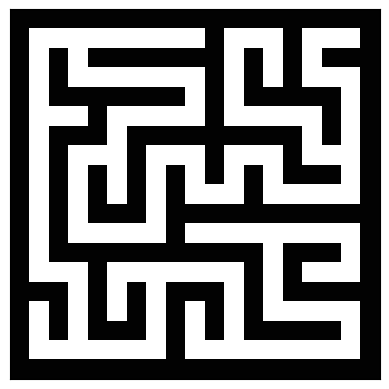

In [7]:
# Pathway carving animation
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)   # seed = 12 has good features in recharge and retraction
demo.action = "carve_pathway_in_steps"
demo.animate(frames=150)                                                # show carving animation from step 0 to 150

# Mold Foraging with Energy Constraint

## 2.1 Mold Foraging

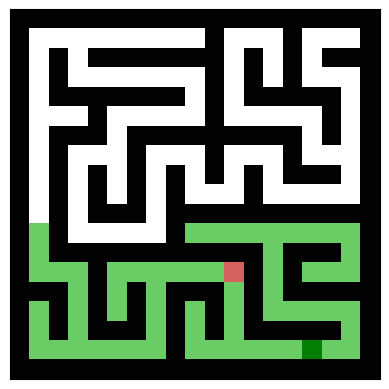

In [8]:
env.action = "forage"
env.step()
env.draw()

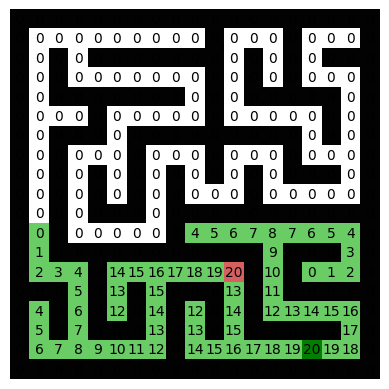

In [9]:
env.draw_with_energy()                                                  # show energy distribution

## 2.2 Progress Visualization

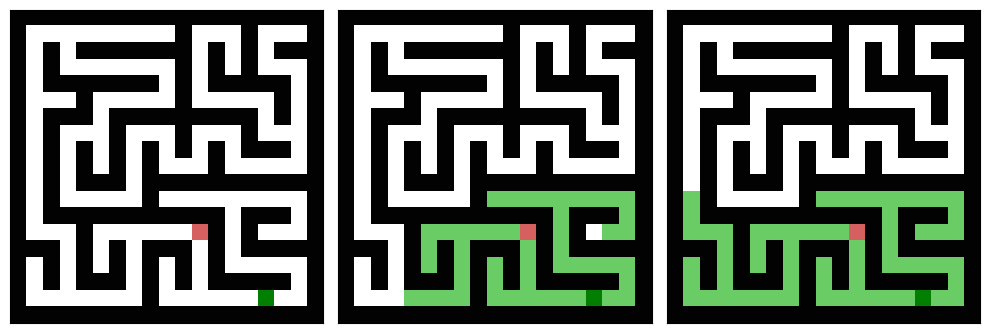

In [10]:
# Mold Foraging frames
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)   # seed = 12 has good features in recharge and inactivation
demo.action = "carve_pathway"
demo.step()
demo.place_item("mold")                                                 # present mold in green
demo.place_item("oat")                                                  # present oat in red
demo.action = "forage_in_steps"
demo.three_frame([0, 50, 100])                                          # display foraging frames at 0, 50 and 150 steps

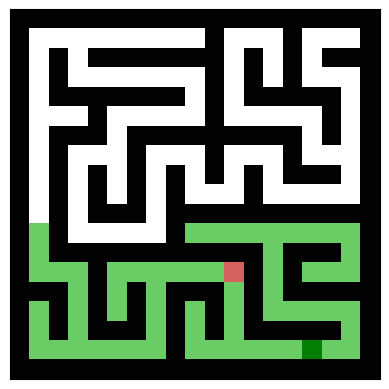

In [11]:
# Mold foraging animation
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)   # seed = 12 has good features in recharge and inactivation
demo.action = "carve_pathway"
demo.step()
demo.place_item("mold")                                                 # present mold in green
demo.place_item("oat")                                                  # present oat in red
demo.action = "forage_in_steps"
demo.animate(frames=100)                                                # show foraging animation from step 0 to 100

# Mold Retraction Triggered by Starvation

## 3.1 Mold Retraction

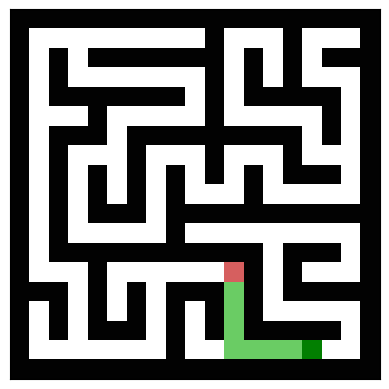

In [12]:
env.action = "retract"
env.step()
env.draw()

## 3.2 Progress Visualization

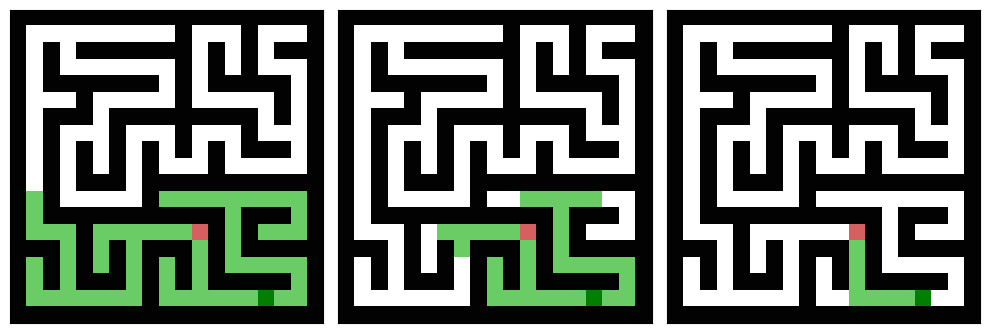

In [13]:
# Mold retraction frames
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)    # seed = 12 has good features in recharge and retraction
demo.action = "carve_pathway"
demo.step()
demo.place_item("mold")                                                  # present mold in green
demo.place_item("oat")                                                   # present oat in red
demo.action = "forage"
demo.step()                                                              # present oat in red
demo.action = "retract_in_steps"
demo.three_frame([0, 30, 30])                                            # display retraction frames at 0, 30 and 60 steps

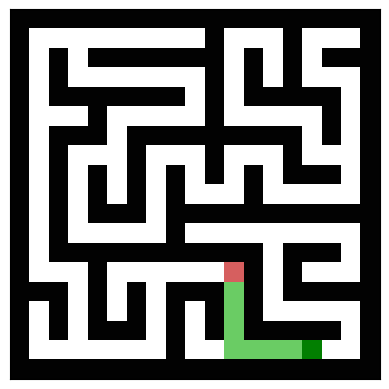

In [14]:
# Mold retraction animation
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)   # seed = 12 has good features in recharge and retraction
demo.action = "carve_pathway"
demo.step()
demo.place_item("mold")                                                 # present mold in green
demo.place_item("oat")                                                  # present oat in red
demo.action = "forage"
demo.step()
demo.action = "retract_in_steps"
demo.animate(frames=80)                                                # show foraging animation from step 0 to 80

# Survival Rate Curve

'\nCaution:\nO(n³) time complexity for 200,000 times simulation.\nExpected runtime could be several minutes.\n'

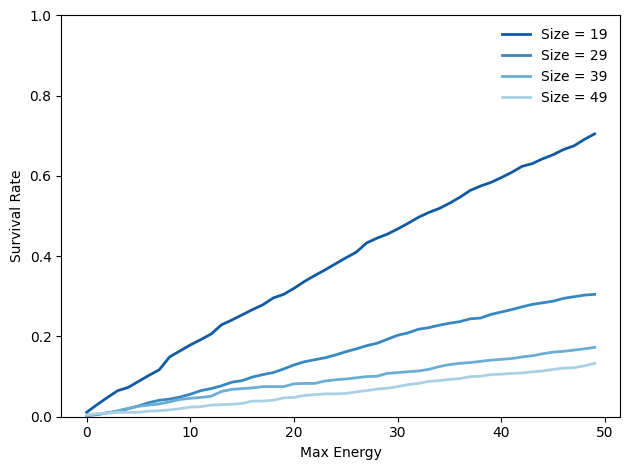

In [16]:
from utils import set_palette, decorate
set_palette('Blues', 5, reverse=True)

for p in [19,29,39,49]:
    segs = []
    for energy in range(50):
        is_find = 0
        num_simu = 1000
        for seeds in range(num_simu):
            demo = SlimeMoldForaging(height=p, width=p, max_energy=energy, seed=seeds)
            demo.action = "carve_pathway"
            demo.step()
            demo.place_item("mold")
            demo.place_item("oat")
            demo.action = "forage"
            demo.step()
            is_find += demo.find_oat()
        p_find = is_find / num_simu
        segs.append(p_find)
    plt.plot(segs, label='Size = %d' % p)

decorate(xlabel='Max Energy', ylabel='Survival Rate', loc='best', ylim=[0, 1])

"""
Caution:
O(n³) time complexity for 200,000 times simulation.
Expected runtime could be several minutes.
"""

# Development Logs

> 5 Oct, 2024
* Begin logging
* Introduce energy constraint in `forage_step()`
  * Add `energy: np.ndarray` as energy map of maze
* Add `draw_with_energy()` to visualize energy loss when foraging
  * Swap the index of `'green'` and `'light_green'` in **Custom Color Map**
* Unify random seeds for visualiazation to achieve reliable reproduction

> 6 Oct, 2024
* Update **Setup**
  * Add `!pip install scipy` for the local execution of cross-correlation principle
* Git-based multiple cooperation
  * Init logs there
  * Unify variable naming style between `carve_pathway_step` and `forage_step()`

> 7 Oct, 2024
* Port `three_frame()` from `utils.py`
* Update **Setup**
  * Remove redundant `mkdir` in **Setup**
* Add `die_step()`
* Add **Survival Rate Curve**

> 8 Oct, 2024
* Add markdown subtitles and format them
* Rename `die_step()` -> `retract_step`
* Remove `!pip install scipy` in **Setup**
* Rewrite function comments in English
* Remove **NumPy Array Quick Reviews**
* Improving Aesthetics of **Survival Rate Curve**

> 9 Oct, 2024
* Update title
* Add caution comment in **Survival Rate Curve**

> Todo
* 拆墙，把迷宫改为培养皿，简单的多燕麦网络模型
  * 去除`place_item()`的数量限制